In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score

In [2]:
path = "data.csv"

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)


data = pd.read_csv(path)
#data.sort_values(by=['id'])

display(data.head())

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  compactness_mean  concavity_mean  concave points_mean  symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  area_se  smoothness_se  compactness_se  concavity_se  concave points_se  symmetry_se  fractal_dimension_se  radius_worst  texture_worst  perimeter_worst  area_worst  smoothness_worst  compactness_worst  concavity_worst  concave points_worst  symmetry_worst  fractal_dimension_worst  Unnamed: 32
0    842302         M        17.99         10.38          122.80     1001.0          0.11840           0.27760          0.3001              0.14710         0.2419                 0.07871     1.0950      0.9053         8.589   153.40       0.006399         0.04904       0.05373            0.01587      0.03003              0.006193         25.38          17.33           184.60      2019.0            0.1622             0.6656           0.7119                0.2654          0.4601                  0.11890          NaN
1    842517         M        20.57         17.77          132.90     1326.0          0.08474           0.07864          0.0869              0.07017         0.1812                 0.05667     0.5435      0.7339         3.398    74.08       0.005225         0.01308       0.01860            0.01340      0.01389              0.003532         24.99          23.41           158.80      1956.0            0.1238             0.1866           0.2416                0.1860          0.2750                  0.08902          NaN
2  84300903         M        19.69         21.25          130.00     1203.0          0.10960           0.15990          0.1974              0.12790         0.2069                 0.05999     0.7456      0.7869         4.585    94.03       0.006150         0.04006       0.03832            0.02058      0.02250              0.004571         23.57          25.53           152.50      1709.0            0.1444             0.4245           0.4504                0.2430          0.3613                  0.08758          NaN
3  84348301         M        11.42         20.38           77.58      386.1          0.14250           0.28390          0.2414              0.10520         0.2597                 0.09744     0.4956      1.1560         3.445    27.23       0.009110         0.07458       0.05661            0.01867      0.05963              0.009208         14.91          26.50            98.87       567.7            0.2098             0.8663           0.6869                0.2575          0.6638                  0.17300          NaN
4  84358402         M        20.29         14.34          135.10     1297.0          0.10030           0.13280          0.1980              0.10430         0.1809                 0.05883     0.7572      0.7813         5.438    94.44       0.011490         0.02461       0.05688            0.01885      0.01756              0.005115         22.54          16.67           152.20      1575.0            0.1374             0.2050           0.4000                0.1625          0.2364                  0.07678          NaN

In [3]:
#Finding missing values
null_feat = pd.DataFrame(len(data['id']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey',
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  "Missing Values")

fig = dict(data = [trace], layout=layout)
py.iplot(fig)

#Finding duplicate observations
duplicate = data[data.duplicated()]
duplicate

Empty DataFrame
Columns: [id, diagnosis, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst, Unnamed: 32]
Index: []

In [4]:
#Remove unnecessary variables
data = data.drop(['id', 'Unnamed: 32'], axis = 1)

y = np.array(data.diagnosis.tolist())
data2 = data.copy()
data2.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

#Replace diagnosis values (M = 1, B = 0)
data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)
display(data.head())
display(data.describe())

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  compactness_mean  concavity_mean  concave points_mean  symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  area_se  smoothness_se  compactness_se  concavity_se  concave points_se  symmetry_se  fractal_dimension_se  radius_worst  texture_worst  perimeter_worst  area_worst  smoothness_worst  compactness_worst  concavity_worst  concave points_worst  symmetry_worst  fractal_dimension_worst
0          1        17.99         10.38          122.80     1001.0          0.11840           0.27760          0.3001              0.14710         0.2419                 0.07871     1.0950      0.9053         8.589   153.40       0.006399         0.04904       0.05373            0.01587      0.03003              0.006193         25.38          17.33           184.60      2019.0            0.1622             0.6656           0.7119                0.2654          0.4601                  0.11890
1          1        20.57         17.77          132.90     1326.0          0.08474           0.07864          0.0869              0.07017         0.1812                 0.05667     0.5435      0.7339         3.398    74.08       0.005225         0.01308       0.01860            0.01340      0.01389              0.003532         24.99          23.41           158.80      1956.0            0.1238             0.1866           0.2416                0.1860          0.2750                  0.08902
2          1        19.69         21.25          130.00     1203.0          0.10960           0.15990          0.1974              0.12790         0.2069                 0.05999     0.7456      0.7869         4.585    94.03       0.006150         0.04006       0.03832            0.02058      0.02250              0.004571         23.57          25.53           152.50      1709.0            0.1444             0.4245           0.4504                0.2430          0.3613                  0.08758
3          1        11.42         20.38           77.58      386.1          0.14250           0.28390          0.2414              0.10520         0.2597                 0.09744     0.4956      1.1560         3.445    27.23       0.009110         0.07458       0.05661            0.01867      0.05963              0.009208         14.91          26.50            98.87       567.7            0.2098             0.8663           0.6869                0.2575          0.6638                  0.17300
4          1        20.29         14.34          135.10     1297.0          0.10030           0.13280          0.1980              0.10430         0.1809                 0.05883     0.7572      0.7813         5.438    94.44       0.011490         0.02461       0.05688            0.01885      0.01756              0.005115         22.54          16.67           152.20      1575.0            0.1374             0.2050           0.4000                0.1625          0.2364                  0.07678

diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  smoothness_mean  compactness_mean  concavity_mean  concave points_mean  symmetry_mean  fractal_dimension_mean   radius_se  texture_se  perimeter_se     area_se  smoothness_se  compactness_se  concavity_se  concave points_se  symmetry_se  fractal_dimension_se  radius_worst  texture_worst  perimeter_worst   area_worst  smoothness_worst  compactness_worst  concavity_worst  concave points_worst  symmetry_worst  fractal_dimension_worst
count  569.000000   569.000000    569.000000      569.000000   569.000000       569.000000        569.000000      569.000000           569.000000     569.000000              569.000000  569.000000  569.000000    569.000000  569.000000     569.000000      569.000000    569.000000         569.000000   569.000000            569.000000    569.000000     569.000000       569.000000   569.000000        569.000000         569.000000       569.000000            569.000000      569.000000               569.000000
mean     0.372583    14.127292     19.289649       91.969033   654.889104         0.096360          0.104341        0.088799             0.048919       0.181162                0.062798    0.405172    1.216853      2.866059   40.337079       0.007041        0.025478      0.031894           0.011796     0.020542              0.003795     16.269190      25.677223       107.261213   880.583128          0.132369           0.254265         0.272188              0.114606        0.290076                 0.083946
std      0.483918     3.524049      4.301036       24.298981   351.914129         0.014064          0.052813        0.079720             0.038803       0.027414                0.007060    0.277313    0.551648      2.021855   45.491006       0.003003        0.017908      0.030186           0.006170     0.008266              0.002646      4.833242       6.146258        33.602542   569.356993          0.022832           0.157336         0.208624              0.065732        0.061867                 0.018061
min      0.000000     6.981000      9.710000       43.790000   143.500000         0.052630          0.019380        0.000000             0.000000       0.106000                0.049960    0.111500    0.360200      0.757000    6.802000       0.001713        0.002252      0.000000           0.000000     0.007882              0.000895      7.930000      12.020000        50.410000   185.200000          0.071170           0.027290         0.000000              0.000000        0.156500                 0.055040
25%      0.000000    11.700000     16.170000       75.170000   420.300000         0.086370          0.064920        0.029560             0.020310       0.161900                0.057700    0.232400    0.833900      1.606000   17.850000       0.005169        0.013080      0.015090           0.007638     0.015160              0.002248     13.010000      21.080000        84.110000   515.300000          0.116600           0.147200         0.114500              0.064930        0.250400                 0.071460
50%      0.000000    13.370000     18.840000       86.240000   551.100000         0.095870          0.092630        0.061540             0.033500       0.179200                0.061540    0.324200    1.108000      2.287000   24.530000       0.006380        0.020450      0.025890           0.010930     0.018730              0.003187     14.970000      25.410000        97.660000   686.500000          0.131300           0.211900         0.226700              0.099930        0.282200                 0.080040
75%      1.000000    15.780000     21.800000      104.100000   782.700000         0.105300          0.130400        0.130700             0.074000       0.195700                0.066120    0.478900    1.474000      3.357000   45.190000       0.008146        0.032450      0.042050           0.014710     0.023480              0.004558     18.790000      29.720000       125.400000  1084.000000          0.146000           0.339100         

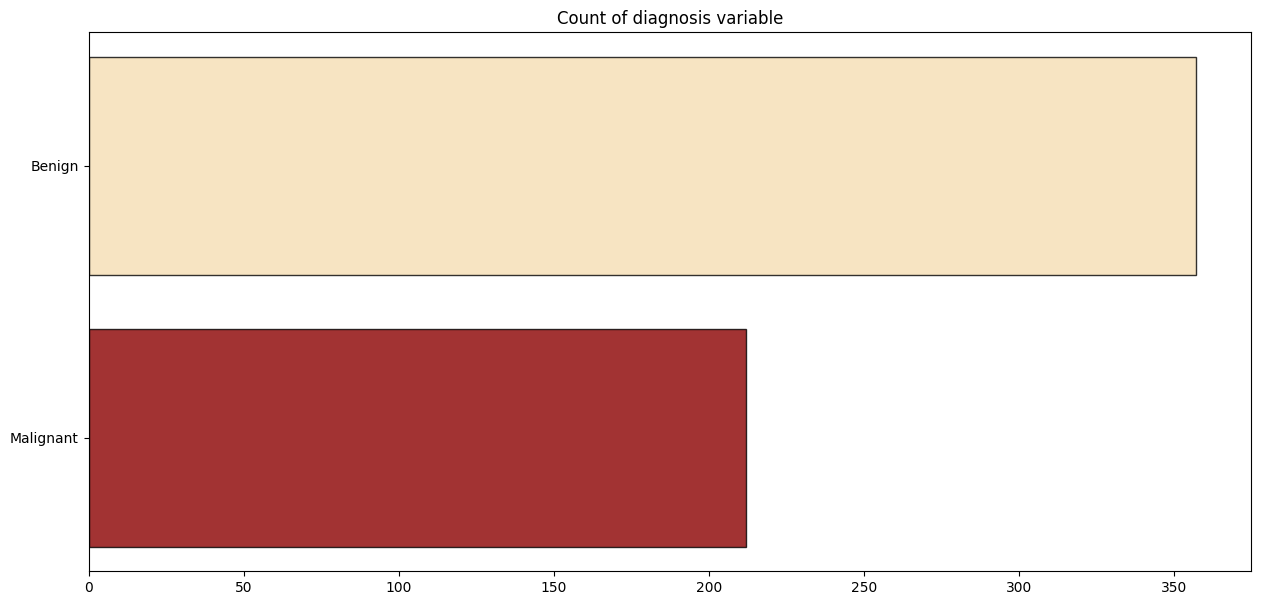

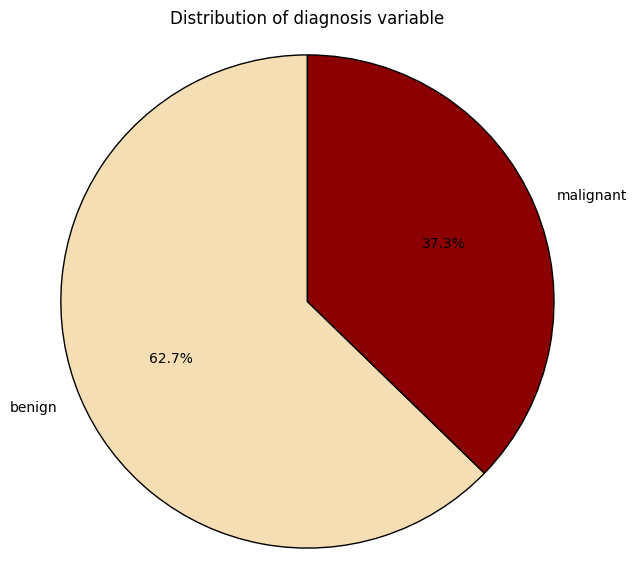

In [5]:
#EDA
M = data[(data['diagnosis'] != 0)]
B = data[(data['diagnosis'] == 0)]
counts = [len(M), len(B)]

#Bar Plot
plt.figure(figsize=(15, 7))
plt.barh(['Malignant', 'Benign'], counts, color=['darkred', 'wheat'], edgecolor='#000000', alpha=0.8)
plt.title('Count of diagnosis variable')
plt.show()

#Pie Chart
diagnosis_counts = data['diagnosis'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(diagnosis_counts, labels=['benign', 'malignant'], colors=['wheat','darkred'], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=1, edgecolor='#000000'))
plt.axis('equal')
plt.title('Distribution of diagnosis variable')
plt.show()

In [6]:
#Distribution Plots
def distributionPlots(variable, bin):
  mal = M[variable]
  ben = B[variable]

  plt.figure(figsize=(10, 6))

  sns.kdeplot(mal, color='darkred', label='Malignant', fill=True, linewidth=2)
  sns.kdeplot(ben, color='wheat', label='Benign', fill=True, linewidth=2)

  plt.xlabel(variable)
  plt.ylabel('Density')
  plt.title('Density Plot for ' + variable)

  plt.legend()
  plt.show()

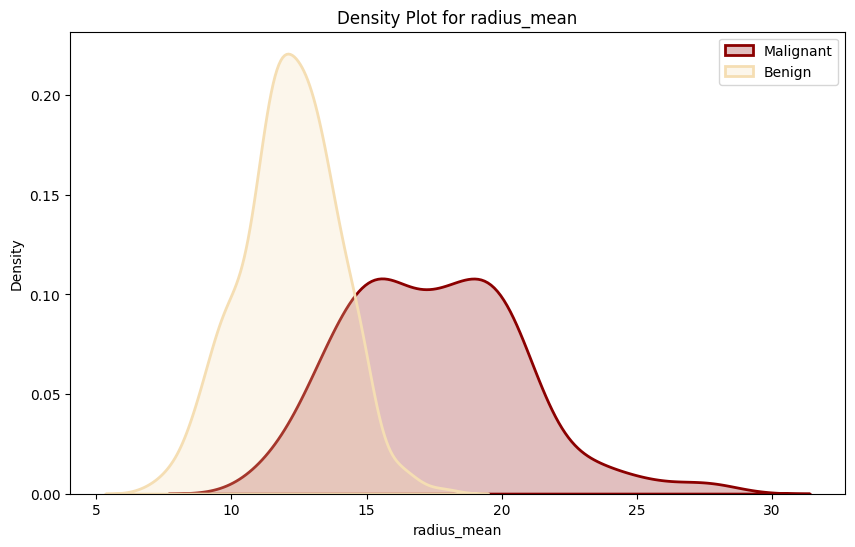

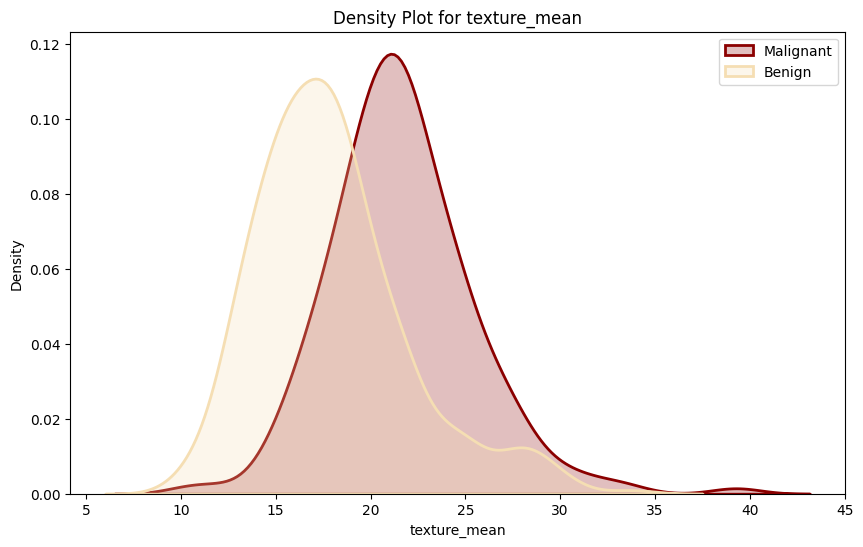

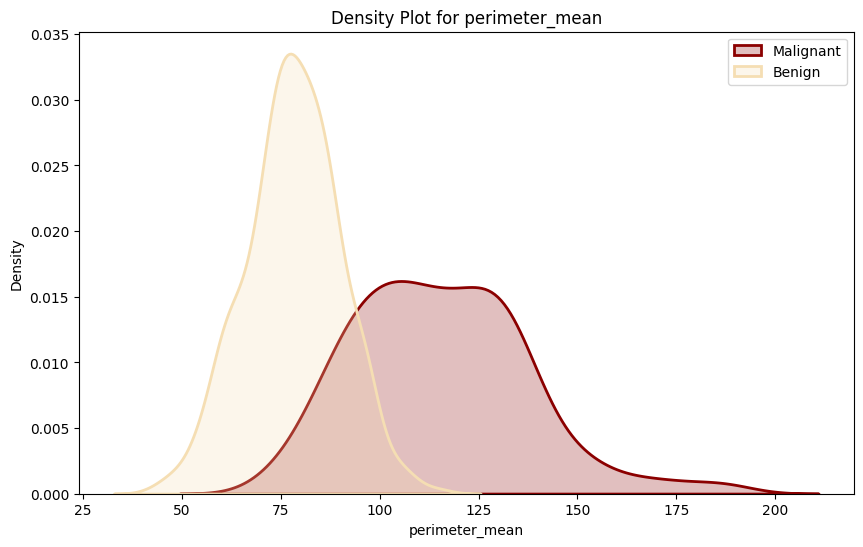

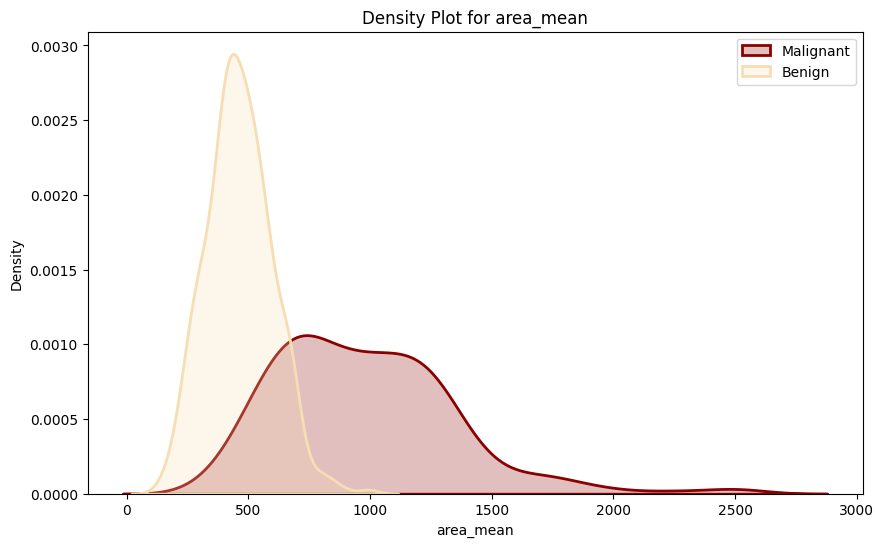

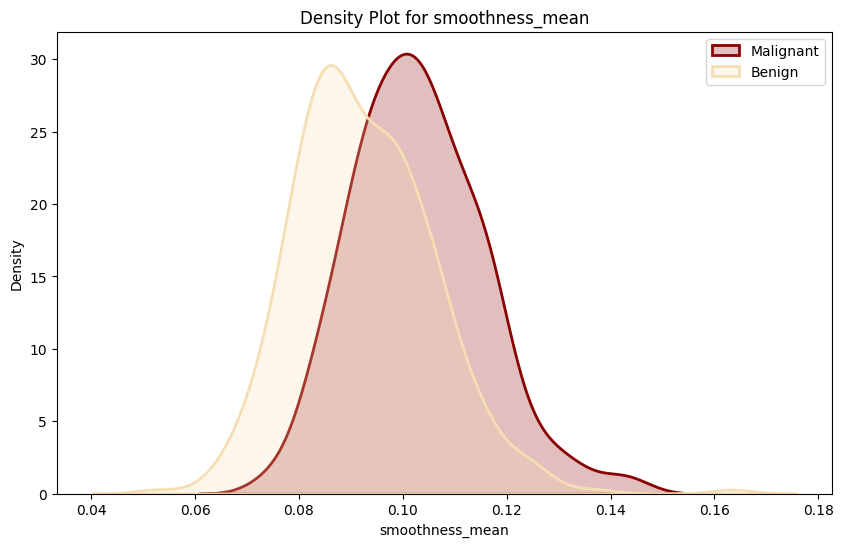

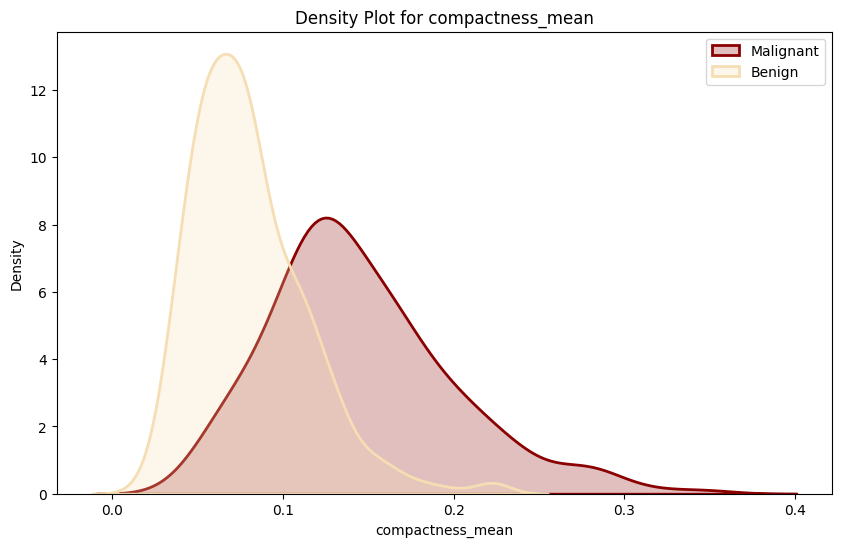

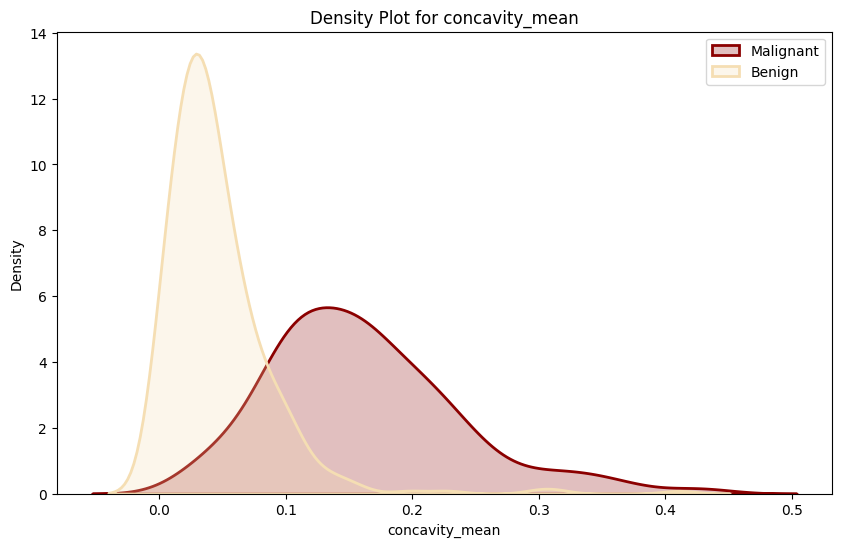

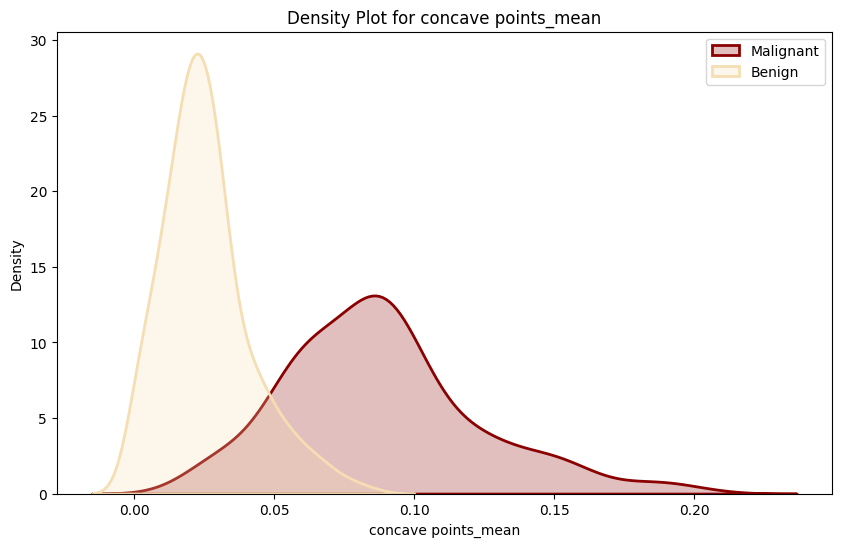

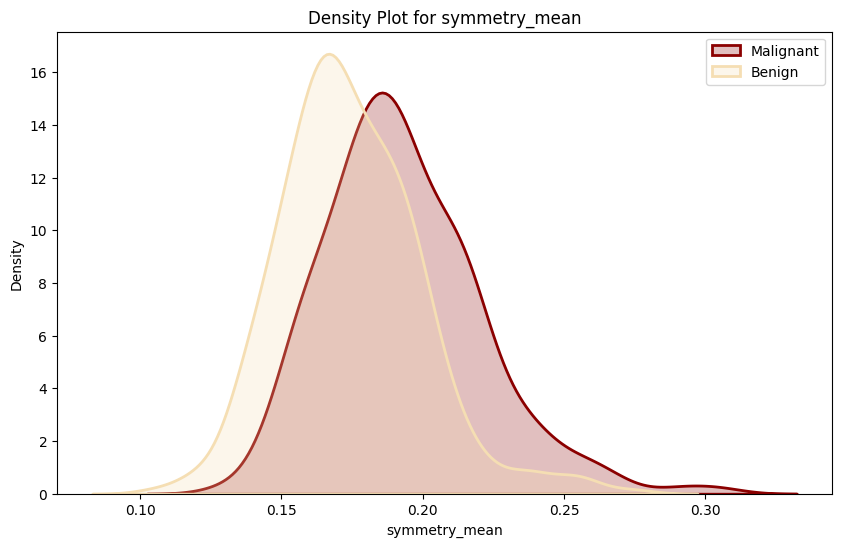

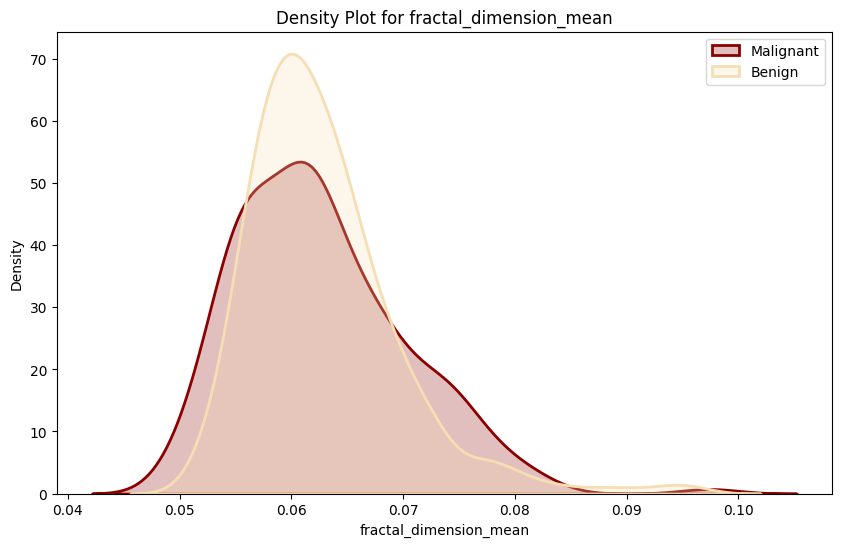

In [7]:
#Mean Features
distributionPlots('radius_mean', .5)
distributionPlots('texture_mean', .5)
distributionPlots('perimeter_mean', 5)
distributionPlots('area_mean', 10)
distributionPlots('smoothness_mean', .5)
distributionPlots('compactness_mean', .5)
distributionPlots('concavity_mean', .5)
distributionPlots('concave points_mean', .5)
distributionPlots('symmetry_mean', .5)
distributionPlots('fractal_dimension_mean', .5)

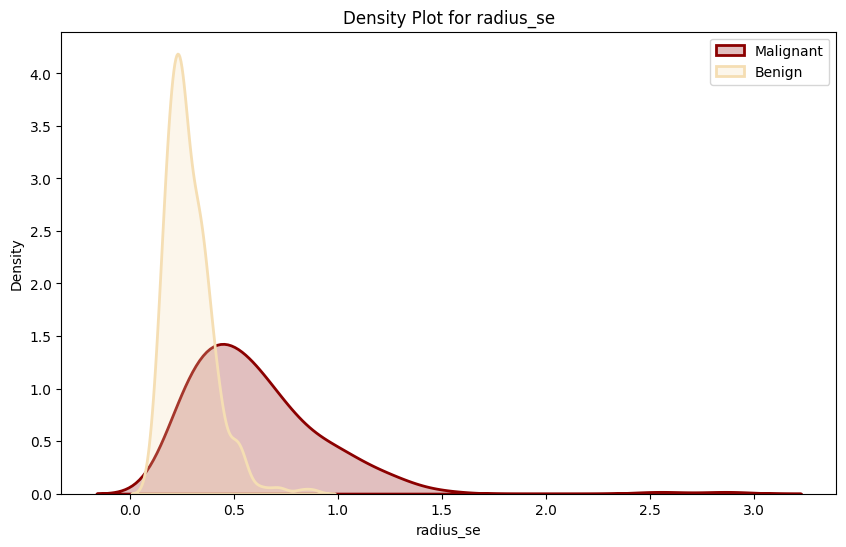

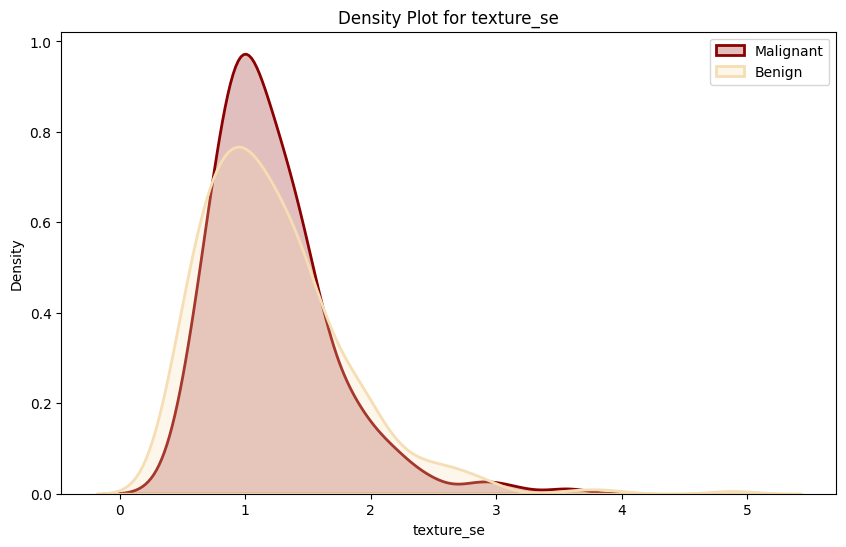

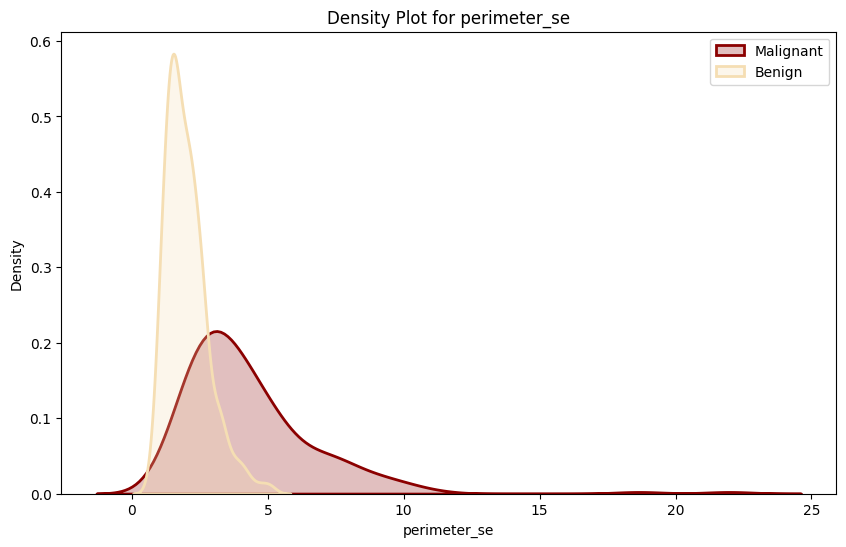

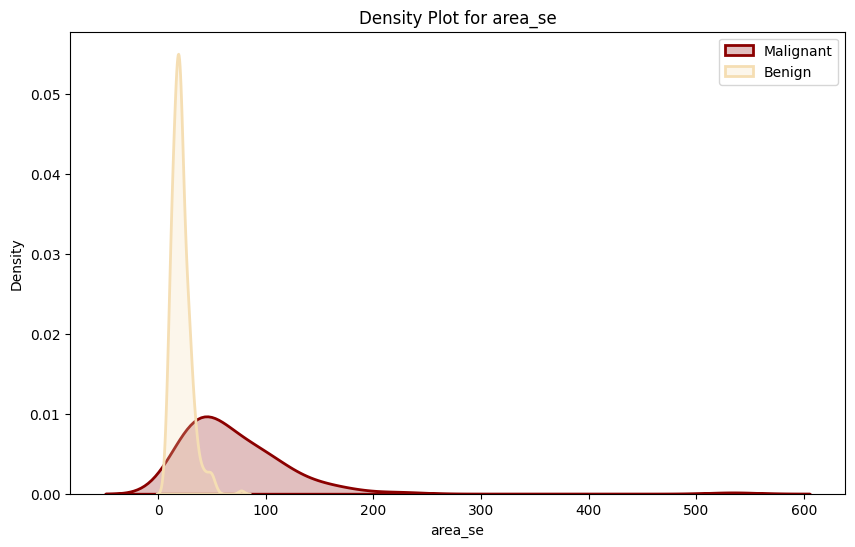

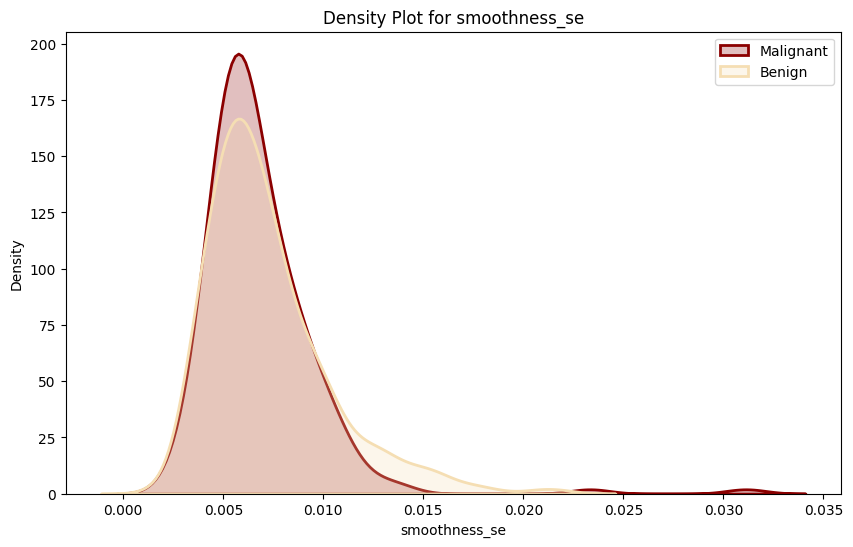

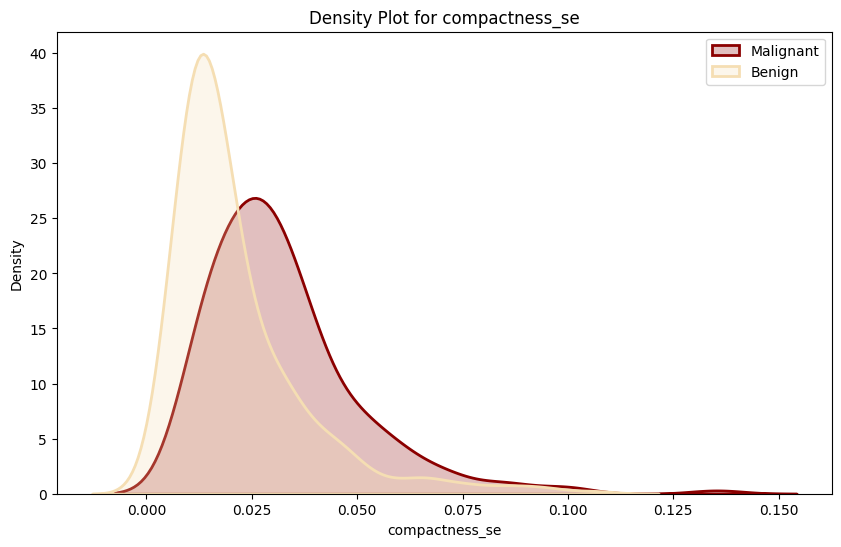

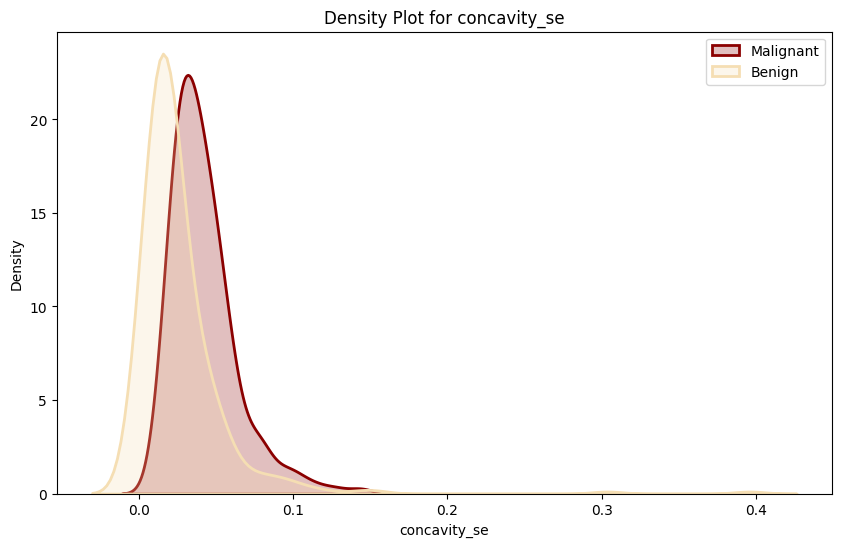

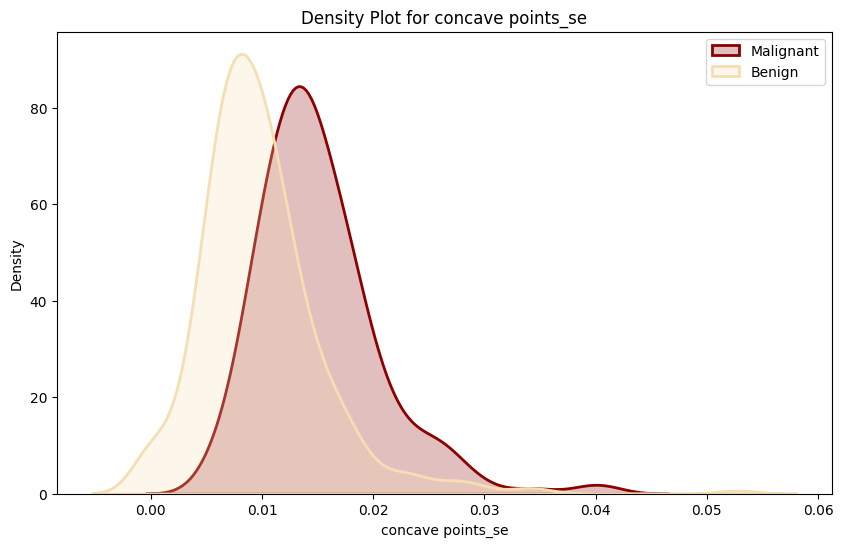

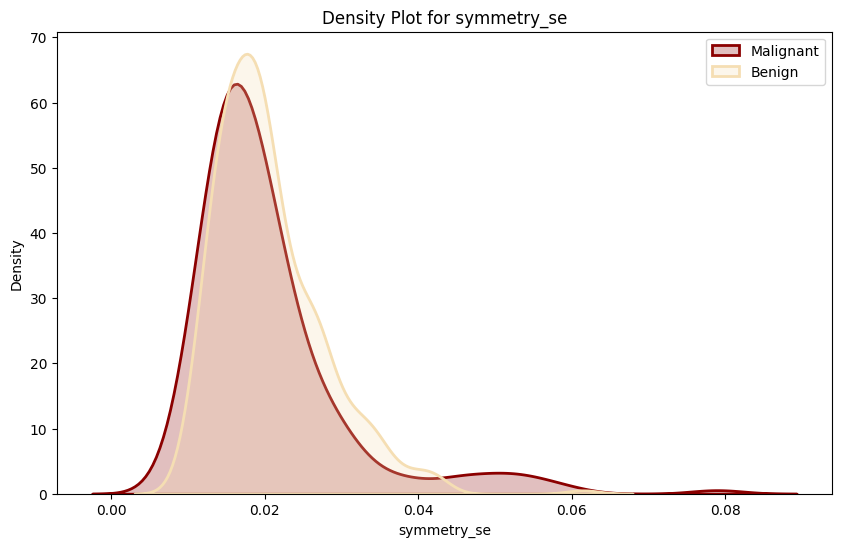

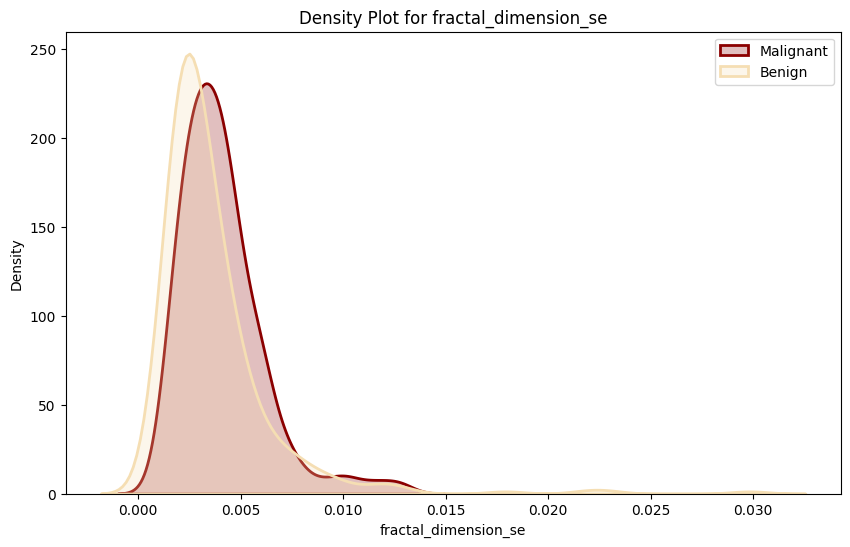

In [8]:
#Standard Error Features
distributionPlots('radius_se', .1)
distributionPlots('texture_se', .1)
distributionPlots('perimeter_se', .5)
distributionPlots('area_se', 5)
distributionPlots('smoothness_se', .5)
distributionPlots('compactness_se', .5)
distributionPlots('concavity_se', .5)
distributionPlots('concave points_se', .5)
distributionPlots('symmetry_se', .5)
distributionPlots('fractal_dimension_se', .5)

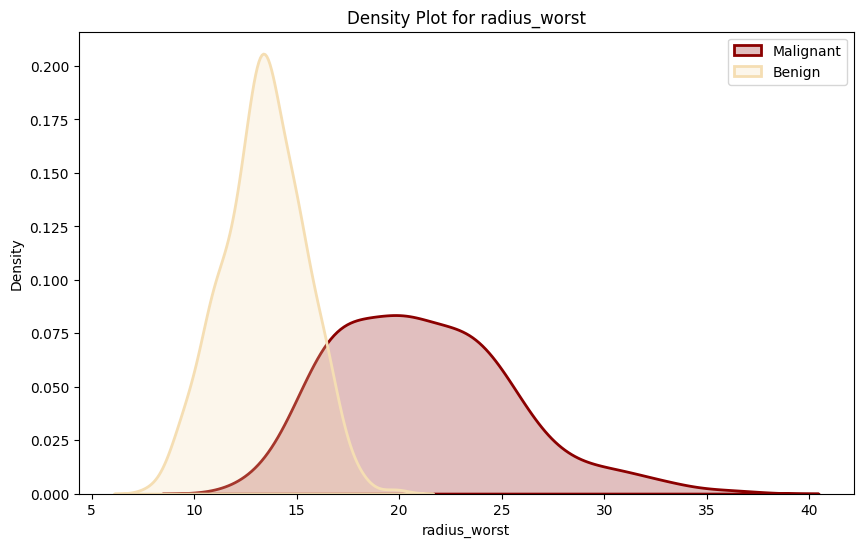

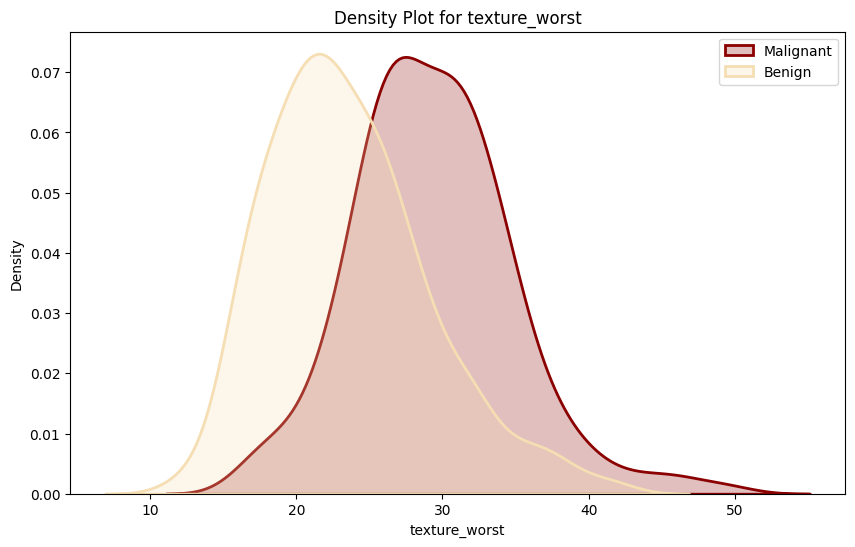

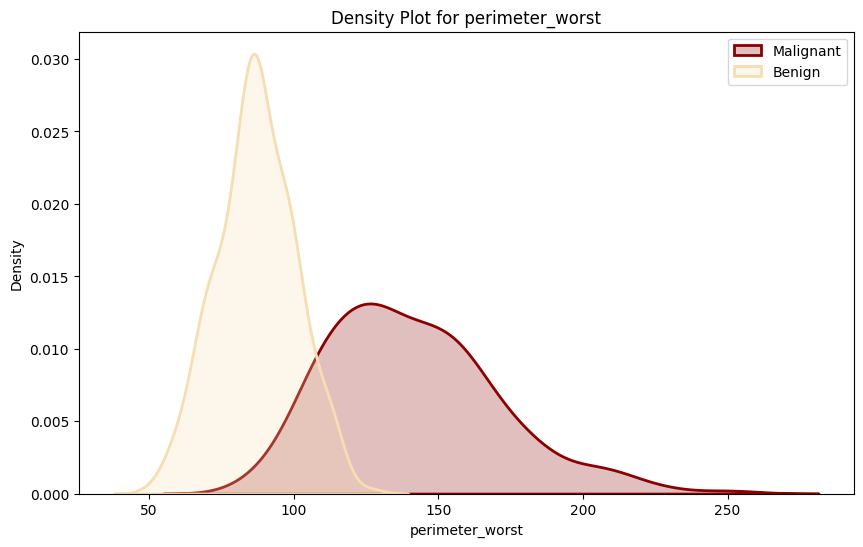

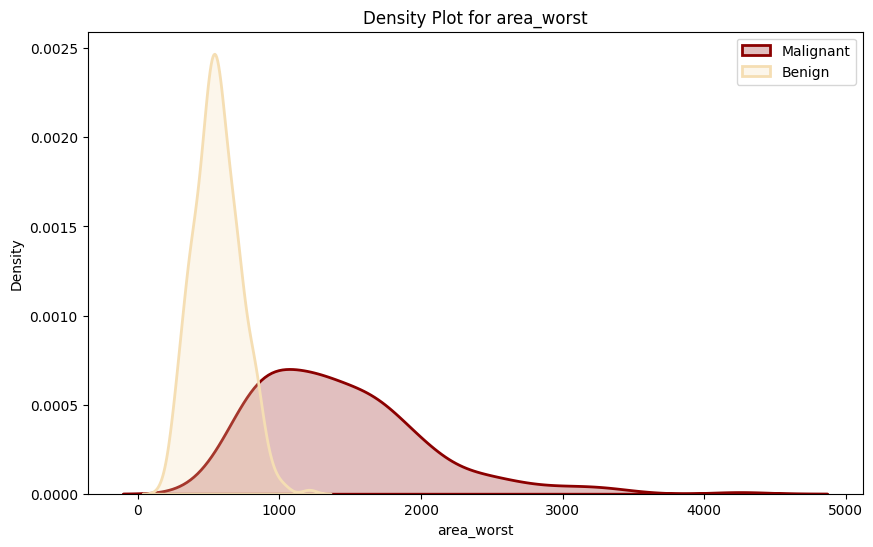

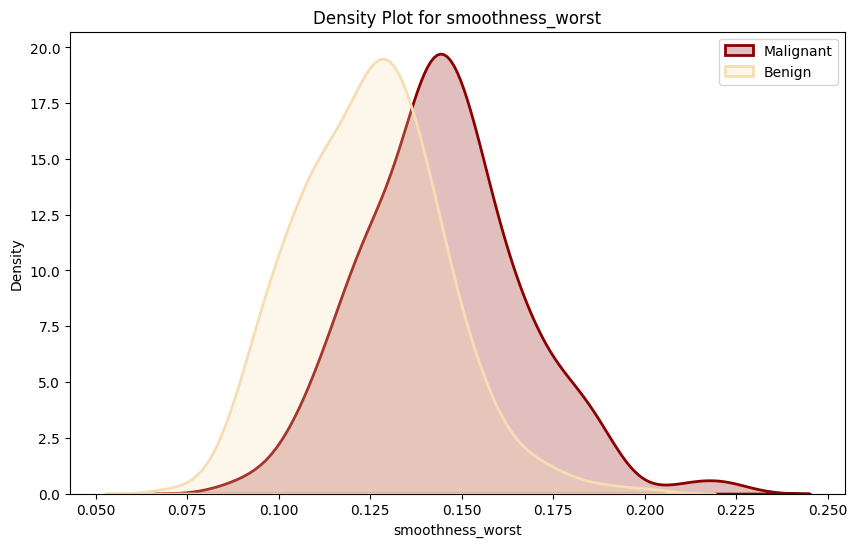

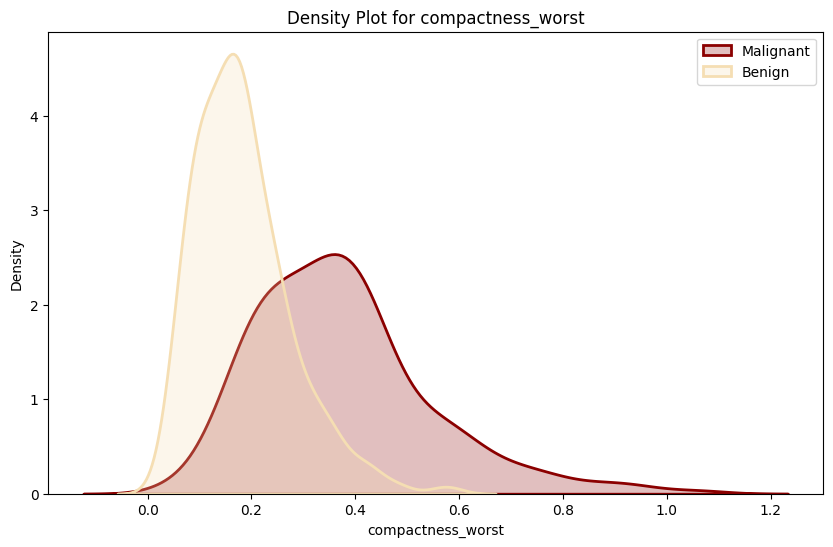

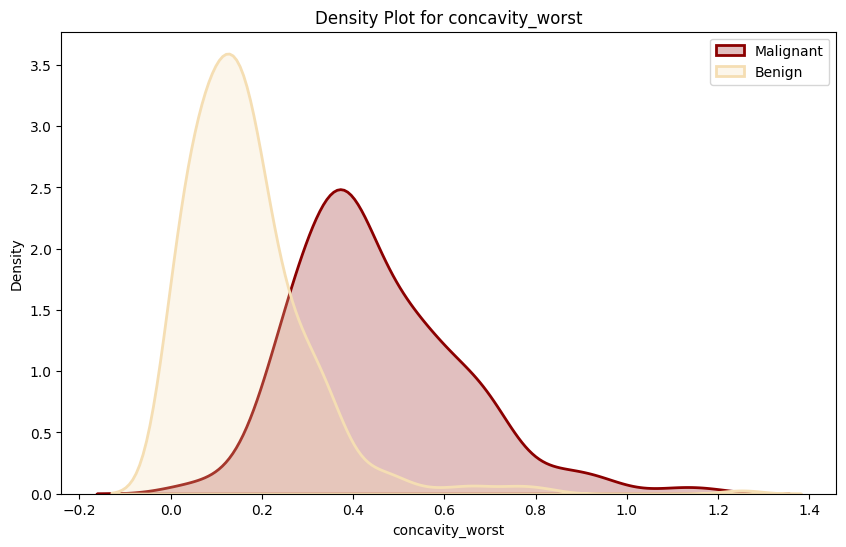

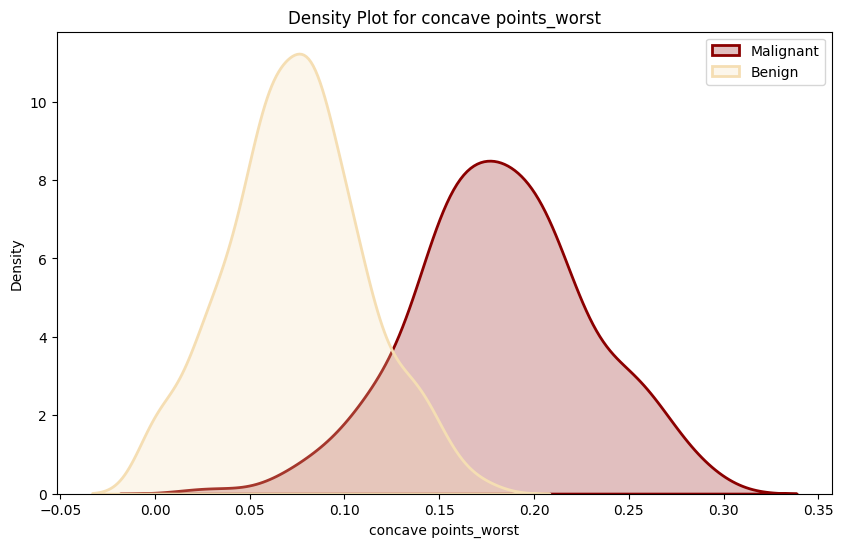

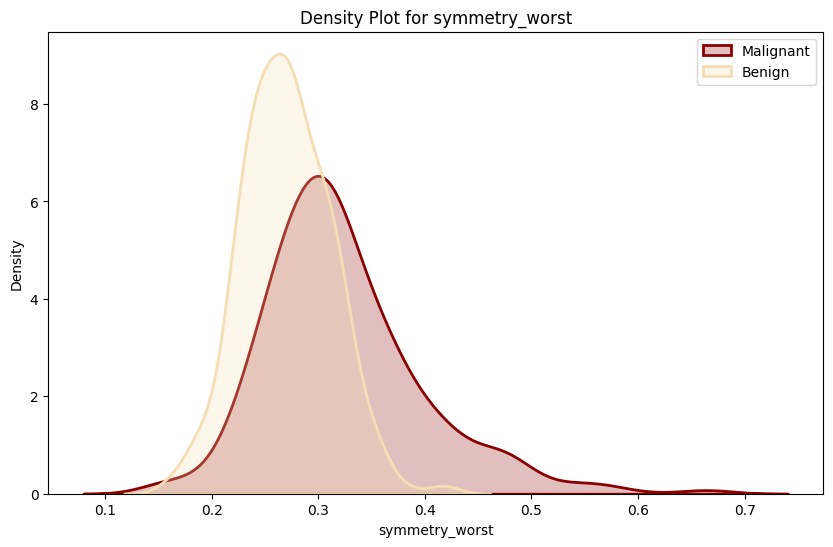

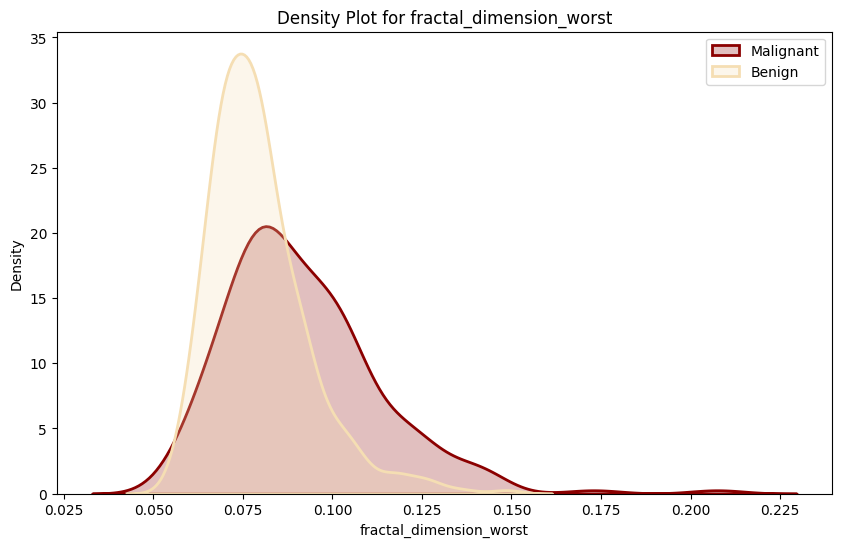

In [9]:
#Worst Features
distributionPlots('radius_worst', .5)
distributionPlots('texture_worst', .5)
distributionPlots('perimeter_worst', 5)
distributionPlots('area_worst', 10)
distributionPlots('smoothness_worst', .5)
distributionPlots('compactness_worst', .5)
distributionPlots('concavity_worst', .5)
distributionPlots('concave points_worst', .5)
distributionPlots('symmetry_worst', .5)
distributionPlots('fractal_dimension_worst', .5)

<Axes: >

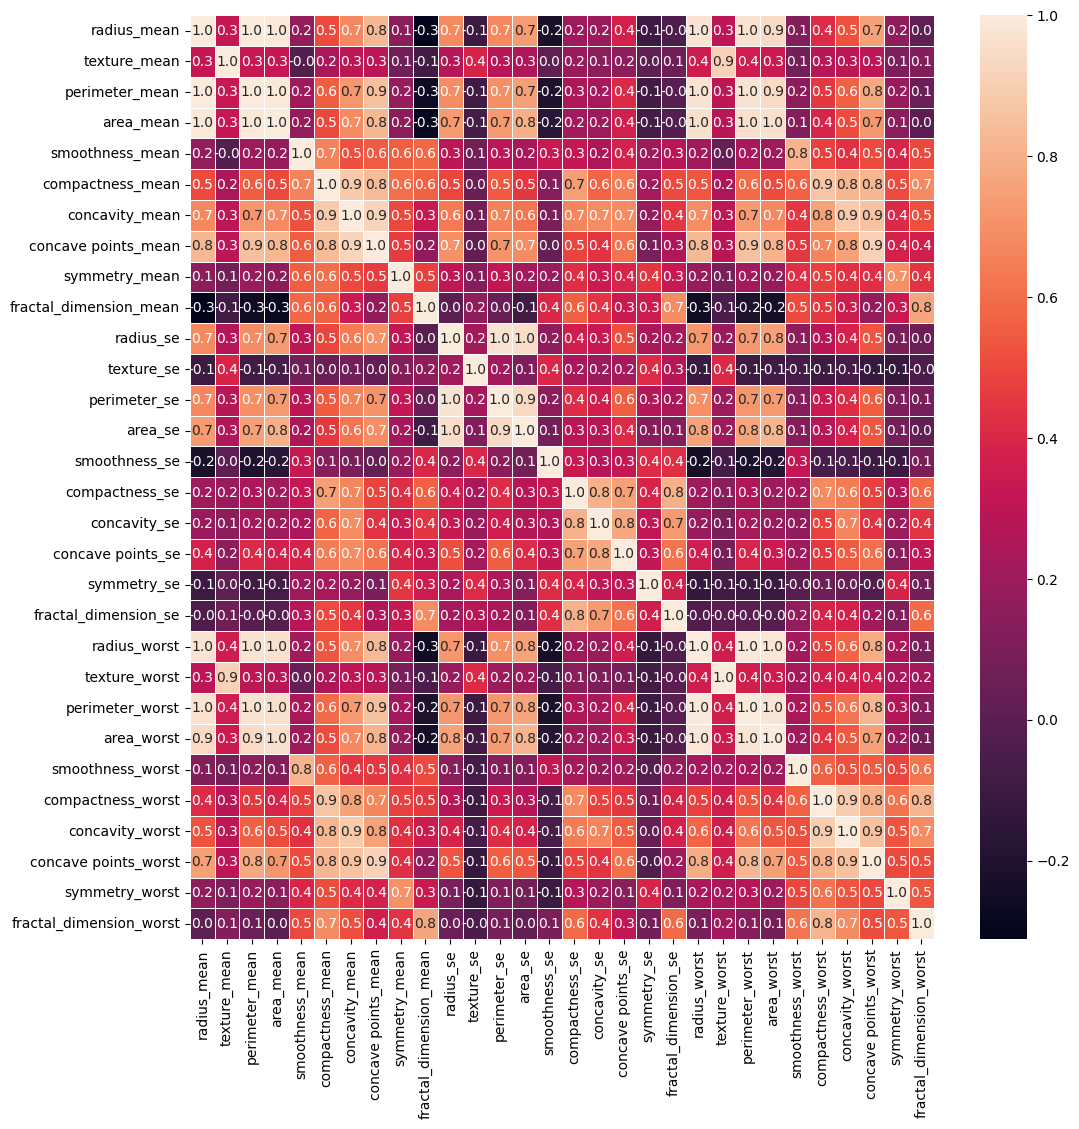

In [10]:
#Correlation Matrix
correlation = data.corr()
predictors = data.drop(['diagnosis'], axis = 1)

f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(predictors.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [11]:
#Scatter Plots
def scatterPlots(data, x1, y1, x2, y2, palette, edgecolor, title):
    diagnosis_labels = {0: 'Malignant', 1: 'Benign'}

    # Plot +
    fig = plt.figure(figsize=(14, 12))

    plt.subplot(221)
    scatter1 = sns.scatterplot(x=data[x1], y=data[y1], hue="diagnosis", data=data, palette=palette, edgecolor=edgecolor)
    scatter1.legend(labels=[diagnosis_labels[label] for label in sorted(data['diagnosis'].unique())])
    plt.title(f'{x1} vs {y1}')

    plt.subplot(222)
    scatter2 = sns.scatterplot(x=data[x2], y=data[y2], hue="diagnosis", data=data, palette=palette, edgecolor=edgecolor)
    scatter2.legend(labels=[diagnosis_labels[label] for label in sorted(data['diagnosis'].unique())])
    plt.title(f'{x2} vs {y2}')

    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    #plt.savefig(title.lower().replace(' ', '_') + '.png')
    plt.show()

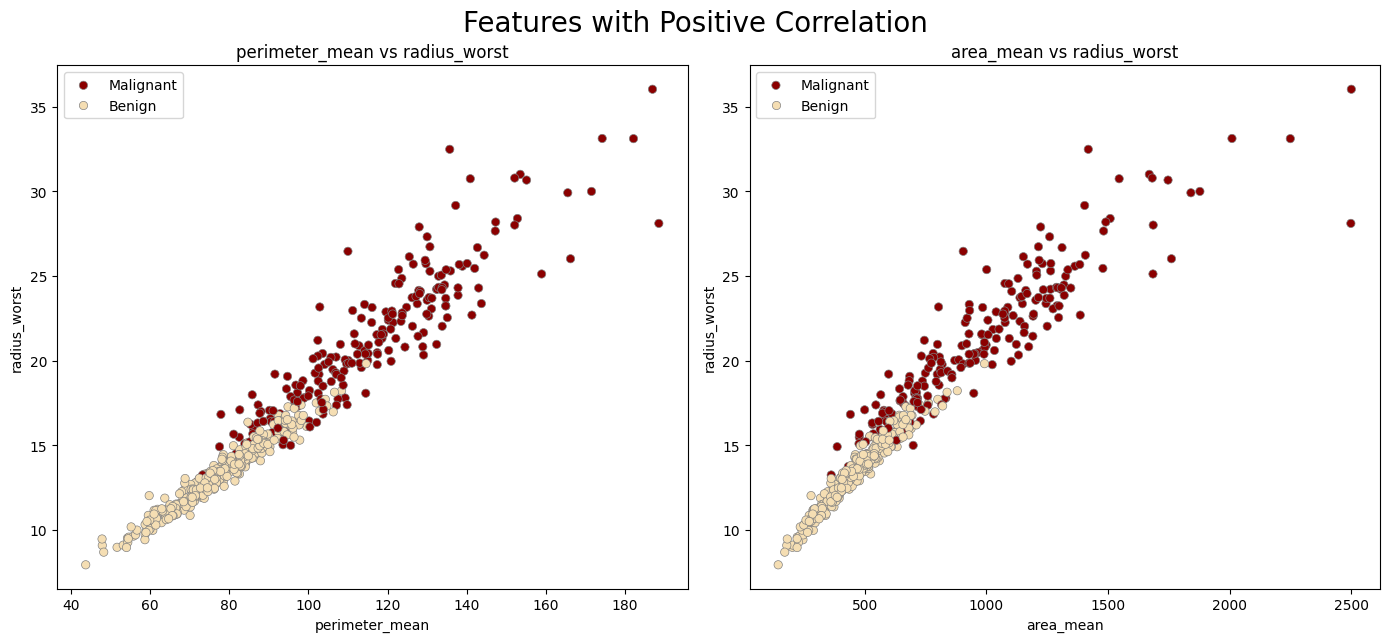

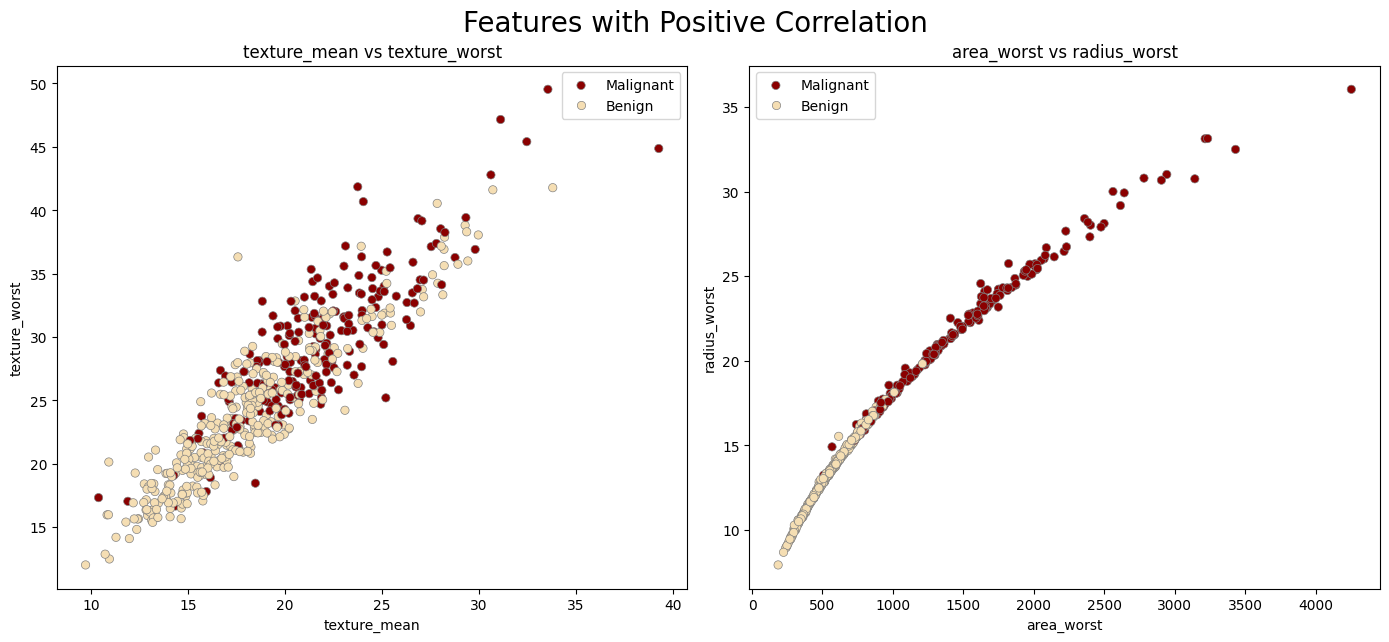

In [12]:
#Features with Positive Correlation
scatterPlots(data, 'perimeter_mean', 'radius_worst', 'area_mean', 'radius_worst', {0: 'wheat', 1: 'darkred'}, 'grey', 'Features with Positive Correlation')
scatterPlots(data, 'texture_mean', 'texture_worst', 'area_worst', 'radius_worst', {0: 'wheat', 1: 'darkred'}, 'grey', 'Features with Positive Correlation')

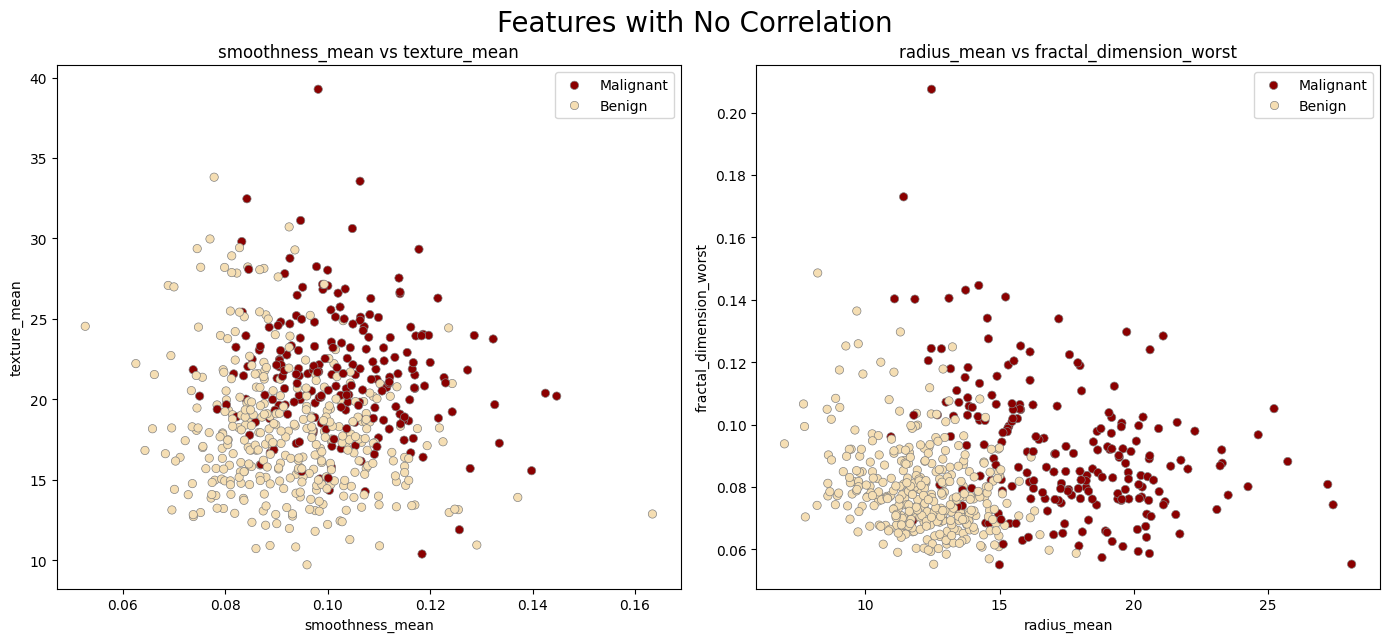

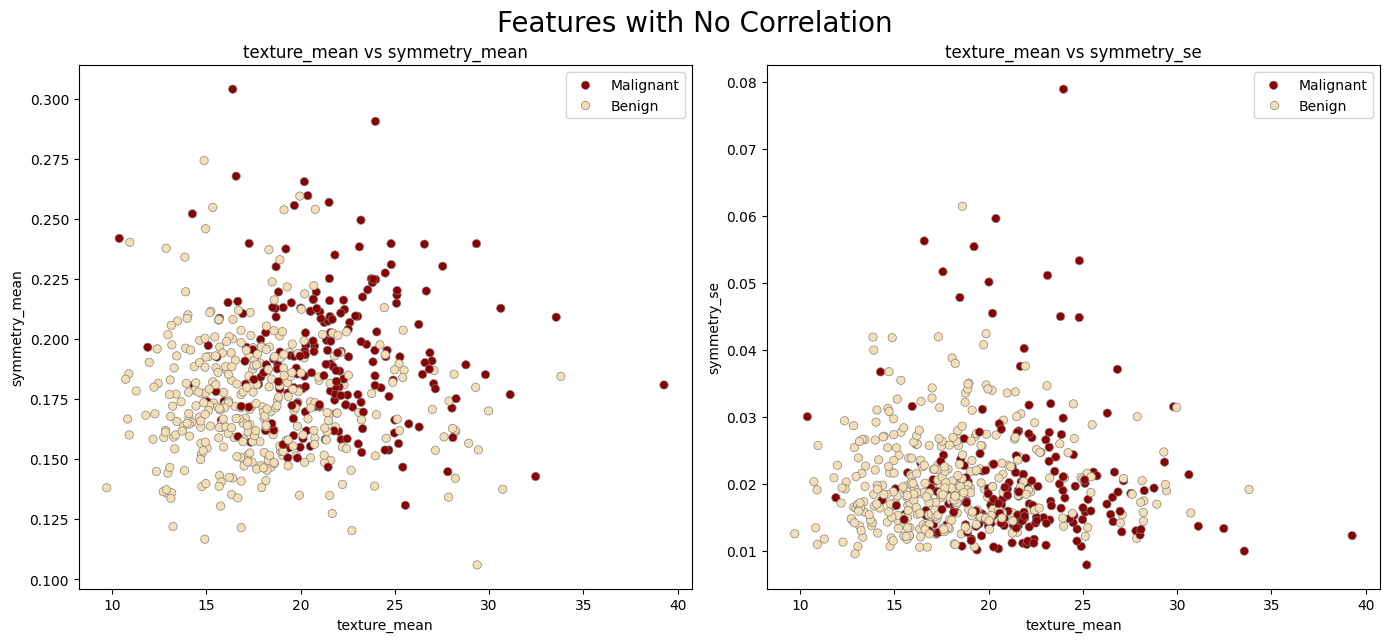

In [13]:
#Features with No Correlation
scatterPlots(data, 'smoothness_mean','texture_mean', 'radius_mean','fractal_dimension_worst', {0: 'wheat', 1: 'darkred'}, 'grey', 'Features with No Correlation')
scatterPlots(data, 'texture_mean','symmetry_mean', 'texture_mean','symmetry_se', {0: 'wheat', 1: 'darkred'}, 'grey', 'Features with No Correlation')

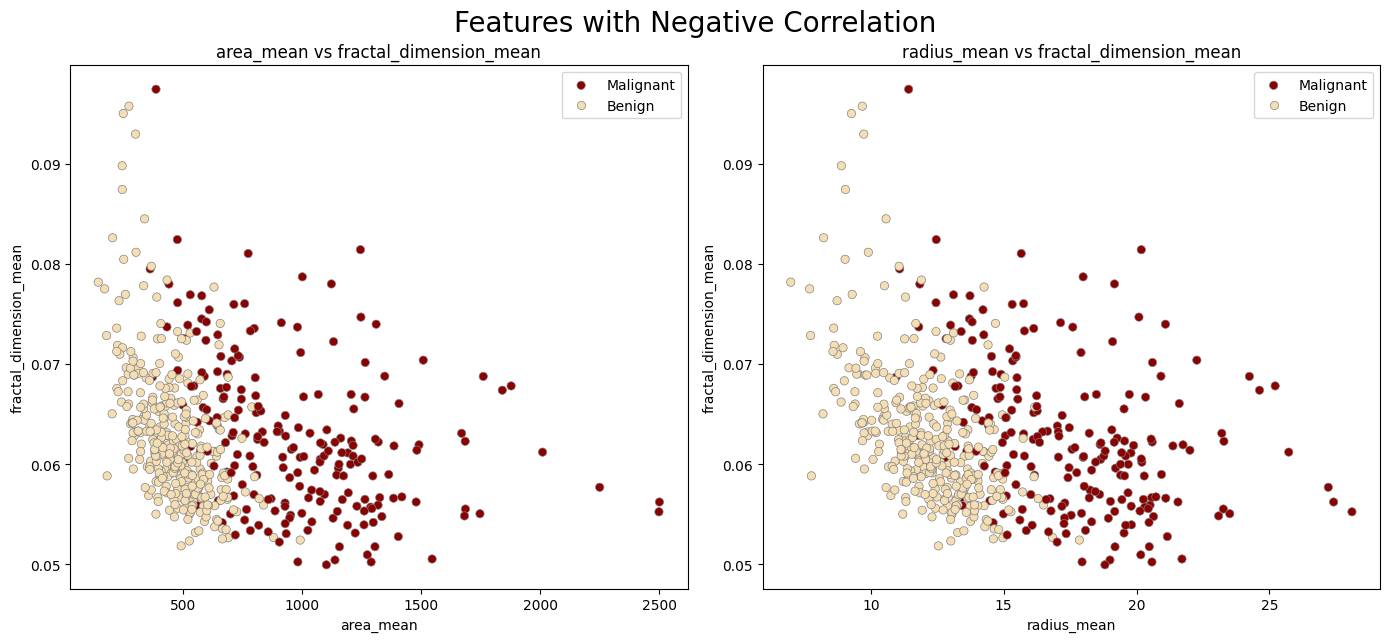

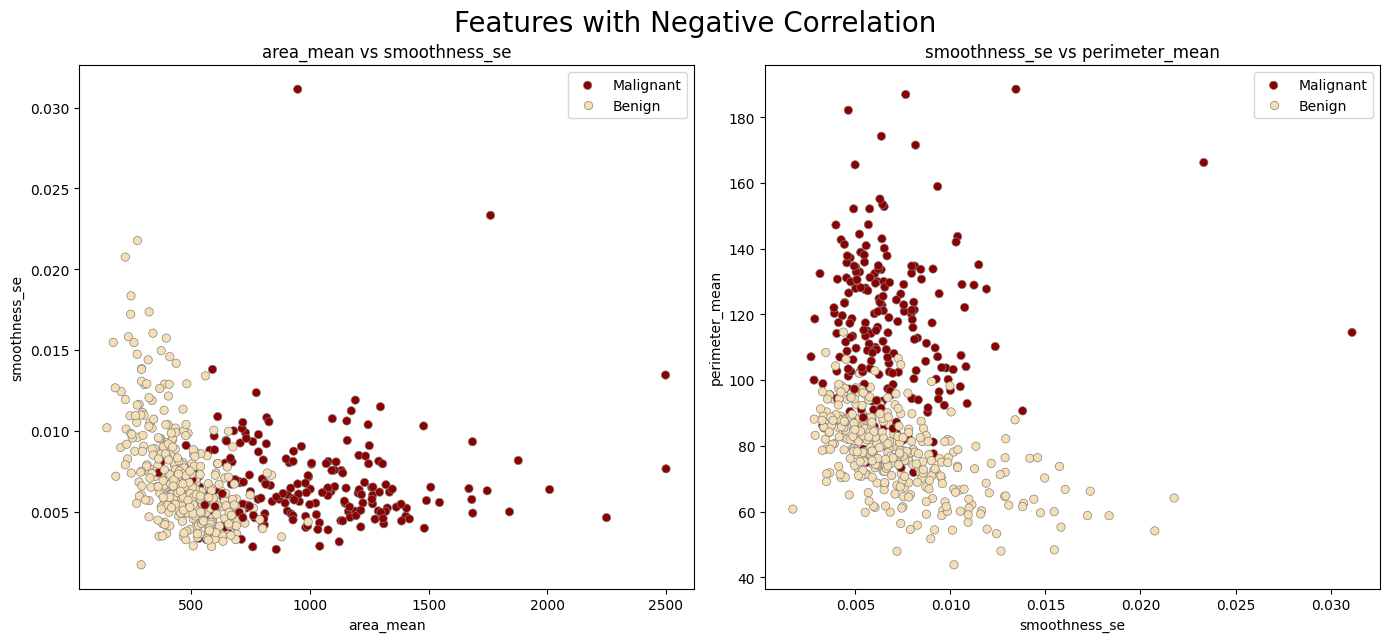

In [14]:
# Features with Neagtive Correlation
scatterPlots(data, 'area_mean','fractal_dimension_mean', 'radius_mean','fractal_dimension_mean', {0: 'wheat', 1: 'darkred'}, 'grey', 'Features with Negative Correlation')
scatterPlots(data, 'area_mean','smoothness_se', 'smoothness_se','perimeter_mean', {0: 'wheat', 1: 'darkred'}, 'grey', 'Features with Negative Correlation')

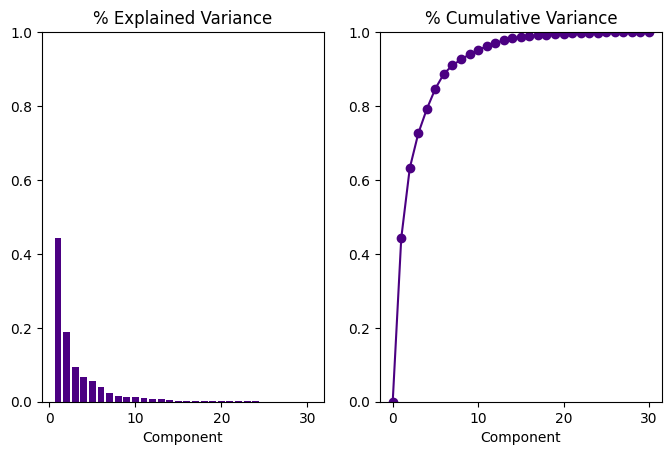

In [15]:
df = pd.read_csv(path)

df = df.drop(['Unnamed: 32', 'id'], axis=1)

df.diagnosis.replace(to_replace=dict(M=1, B=0), inplace=True)

M = df[df['diagnosis'] != 0]
B = df[df['diagnosis'] == 0]

y = np.array(df.diagnosis.tolist())
X = df.drop('diagnosis', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# standardize & PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# convert pc to df
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

# explained variance. using this to select the # best of components
def plot_variance(pca):
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr, color='indigo')
    axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-", color='indigo')
    axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))
    fig.set(figwidth=8, dpi=100)
    plt.show()

plot_variance(pca)

Top three features for PC1: Index(['concave points_mean', 'concavity_mean', 'concave points_worst'], dtype='object')
Top three features for PC2: Index(['fractal_dimension_mean', 'fractal_dimension_se',
       'fractal_dimension_worst'],
      dtype='object')


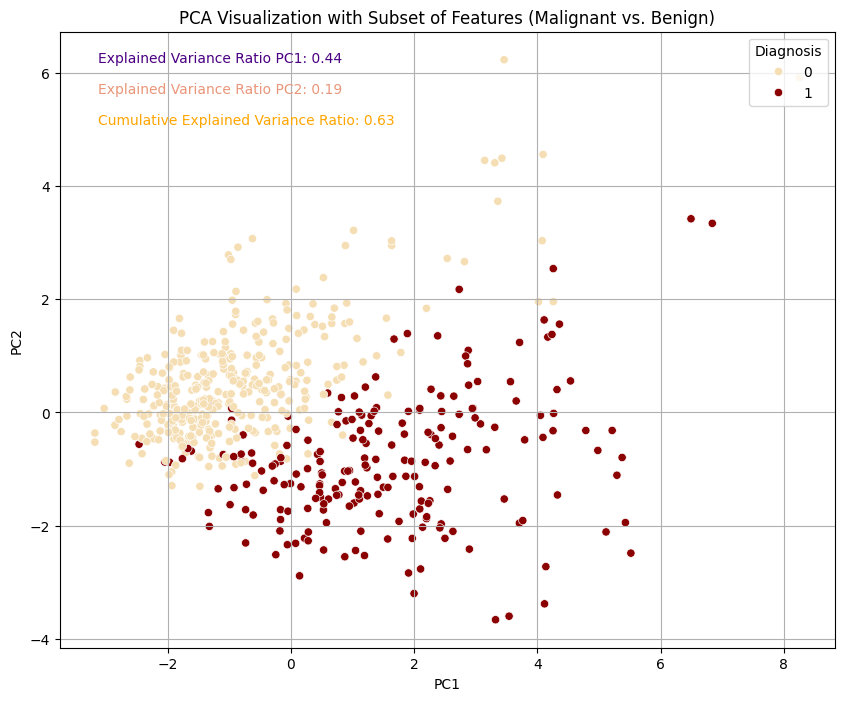

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

loadings = pca.components_
abs_loadings = np.abs(loadings)


# top three for each PC
top_three_indices_pc1 = np.argsort(abs_loadings[0])[::-1][:3]
top_three_indices_pc2 = np.argsort(abs_loadings[1])[::-1][:3]
top_three_features_pc1 = X.columns[top_three_indices_pc1]
top_three_features_pc2 = X.columns[top_three_indices_pc2]
print("Top three features for PC1:", top_three_features_pc1)
print("Top three features for PC2:", top_three_features_pc2)

X_subset = X[top_three_features_pc1.append(top_three_features_pc2)]

# Standardize the subset of features
scaler_subset = StandardScaler()
X_subset_scaled = scaler_subset.fit_transform(X_subset)

#pca using best # of components
pca_subset = PCA(n_components=2)
X_pca_subset = pca_subset.fit_transform(X_subset_scaled)

component_names_subset = [f"PC{i+1}" for i in range(X_pca_subset.shape[1])]
X_pca_subset = pd.DataFrame(X_pca_subset, columns=component_names_subset)

# plot PCA w/ k=2. each PC has features selected using the three highest features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue=y, data=X_pca_subset, palette=['wheat', 'darkred'])
plt.title('PCA Visualization with Subset of Features (Malignant vs. Benign)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Diagnosis', loc='upper right')
plt.grid(True)

#explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.annotate(f'Explained Variance Ratio PC1: {explained_variance_ratio[0]:.2f}', 
             xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='indigo')
plt.annotate(f'Explained Variance Ratio PC2: {explained_variance_ratio[1]:.2f}', 
             xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10, color='darksalmon')
plt.annotate(f'Cumulative Explained Variance Ratio: {cumulative_variance_ratio[1]:.2f}', 
             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='orange')

plt.show()


perimeter_worst            0.473387
area_worst                 0.463288
radius_worst               0.454272
concave points_mean        0.437704
concave points_worst       0.436119
perimeter_mean             0.402936
concavity_mean             0.375148
radius_mean                0.361199
area_mean                  0.359468
area_se                    0.337170
concavity_worst            0.315259
perimeter_se               0.274658
radius_se                  0.245417
compactness_worst          0.226367
compactness_mean           0.216178
concave points_se          0.128491
texture_worst              0.118904
concavity_se               0.109279
smoothness_worst           0.100109
texture_mean               0.094937
symmetry_worst             0.089993
smoothness_mean            0.077111
compactness_se             0.075095
symmetry_mean              0.069241
fractal_dimension_worst    0.061798
fractal_dimension_se       0.035662
smoothness_se              0.018691
symmetry_se                0

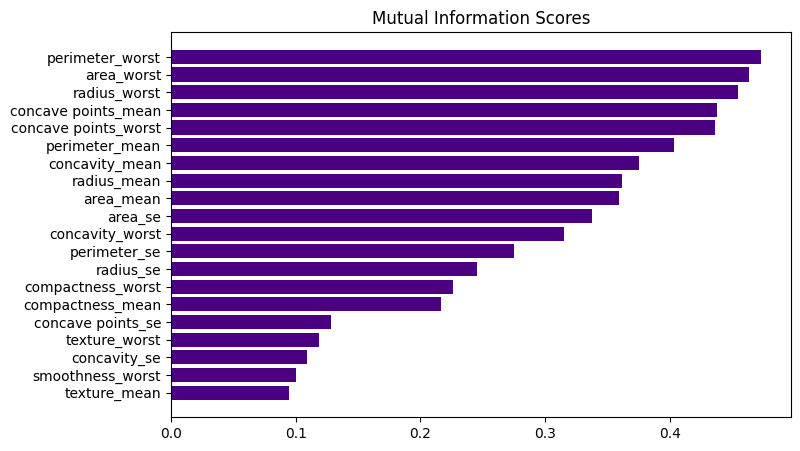

In [17]:

# calculate mutual info scores
def make_mi_scores(X, y):
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores, color='darkred'):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, color=color)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

mi_scores = make_mi_scores(X, y)
print(mi_scores)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20), color='indigo')

In [18]:
# Linear Regression

In [19]:
#Scaling and Splitting Data
y = np.array(data.diagnosis.tolist())
data = data.drop('diagnosis', axis=1)
X = data.values

#Normalizing the Data
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Splitting the Data
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.12, random_state = random_state)

In [20]:
#Logistic Regression
log_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty': ['l1', 'l2'],  
            'solver': ['liblinear'],
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_clf.fit(X_train, y_train)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
The best parameters for using this model is {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [21]:
# Accessing coefficients
coefficients = CV_log_clf.best_estimator_.coef_

# Outputting coefficients
print("Coefficients:")
for i, coef in enumerate(coefficients[0]):
    print(f"Coefficient for feature {i + 1}: {coef}")

Coefficients:
Coefficient for feature 1: 0.36365307094544297
Coefficient for feature 2: 0.4074393127528309
Coefficient for feature 3: 0.3529376427600434
Coefficient for feature 4: 0.3794043268232813
Coefficient for feature 5: 0.12682831311848605
Coefficient for feature 6: -0.029350417935999563
Coefficient for feature 7: 0.38782449793216595
Coefficient for feature 8: 0.4695575981337264
Coefficient for feature 9: 0.08404965184017221
Coefficient for feature 10: -0.2165399524055209
Coefficient for feature 11: 0.515401121391353
Coefficient for feature 12: -0.025325117178481602
Coefficient for feature 13: 0.3702632609240722
Coefficient for feature 14: 0.4127113372849948
Coefficient for feature 15: 0.10052371499309481
Coefficient for feature 16: -0.26630051330797094
Coefficient for feature 17: -0.0687305907073329
Coefficient for feature 18: 0.10021742829318461
Coefficient for feature 19: -0.13301222278020353
Coefficient for feature 20: -0.25309044898746136
Coefficient for feature 21: 0.512019

In [22]:
odds_ratios = np.exp(coefficients)

# Outputting odds ratios
print("Odds Ratios:")
for i, coef in enumerate(odds_ratios[0]):
    print(f"Odds Ratio for feature {i + 1}: {coef}")

Odds Ratios:
Odds Ratio for feature 1: 1.4385750440947966
Odds Ratio for feature 2: 1.5029642320045415
Odds Ratio for feature 3: 1.423242391199154
Odds Ratio for feature 4: 1.4614138051047514
Odds Ratio for feature 5: 1.1352220983075227
Odds Ratio for feature 6: 0.9710761223486043
Odds Ratio for feature 7: 1.4737711117124
Odds Ratio for feature 8: 1.5992865093521276
Odds Ratio for feature 9: 1.087682897925519
Odds Ratio for feature 10: 0.8053003605933824
Odds Ratio for feature 11: 1.6743099686628509
Odds Ratio for feature 12: 0.9749928735617074
Odds Ratio for feature 13: 1.44811579678877
Odds Ratio for feature 14: 1.5109088199367307
Odds Ratio for feature 15: 1.1057498642435377
Odds Ratio for feature 16: 0.7662088369478764
Odds Ratio for feature 17: 0.9335781608330143
Odds Ratio for feature 18: 1.1054112396274478
Odds Ratio for feature 19: 0.8754543915567699
Odds Ratio for feature 20: 0.7763976542660842
Odds Ratio for feature 21: 1.6686578115340118
Odds Ratio for feature 22: 1.78204177

In [23]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

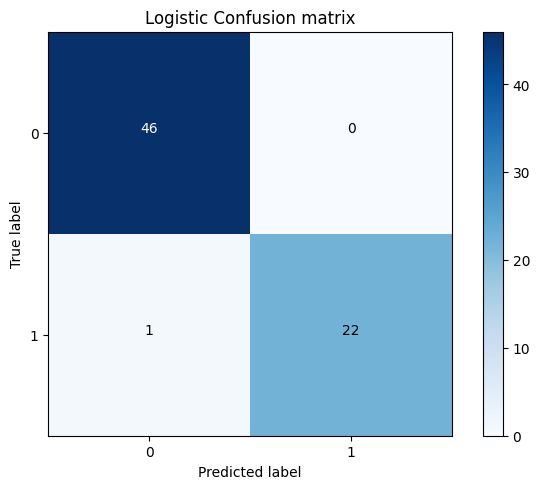

Accuracy  =     0.986
Precision =     1.000
Recall    =     0.957
F1_score  =     0.978


In [24]:
CV_log_clf = LogisticRegression(C = best_parameters['C'], 
                                penalty = best_parameters['penalty'], 
                                random_state = random_state)

CV_log_clf.fit(X_train, y_train)
y_pred = CV_log_clf.predict(X_test)
y_score = CV_log_clf.decision_function(X_test)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
# plt.savefig('6')
plt.show()

show_metrics()

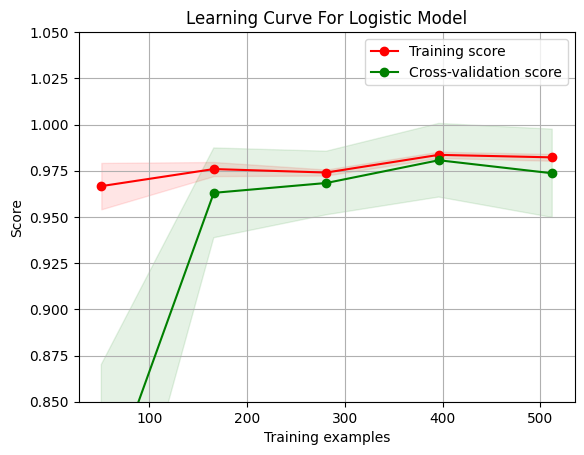

In [25]:
# Plotting Learning Curve
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

plot_learning_curve(CV_log_clf, 'Learning Curve For Logistic Model', X, y, (0.85,1.05), 10)
plt.show()

In [26]:
# Cross Validation
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

cross_log = cross_val_metrics(CV_log_clf)

[accuracy] : 0.97541 (+/- 0.00653)
[precision] : 0.99024 (+/- 0.01196)
[recall] : 0.94352 (+/- 0.01856)
